# Head Rotation with TP-GAN
Code adapted from:
  - [Pix2Pix Tensor flow docs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb).
  - [LightCNN](https://github.com/AlfredXiangWu/LightCNN)
  - [TP-GAN official implementation](https://github.com/HRLTY/TP-GAN)
  - [TP-GAN Keras implementation](https://github.com/yh-iro/Keras_TP-GAN)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import os
import time
import datetime
import gc
from PIL import Image

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, \
LeakyReLU, Input, Flatten, Dense, Maximum, Lambda, Concatenate, Reshape, Add, MaxPooling2D, \
AveragePooling2D, Dropout, Average, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import Zeros, TruncatedNormal, RandomNormal, Constant
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.regularizers as regularizers

In [2]:
print(tf.__version__)

2.2.0-dev20200421


## Load the dataset

In [3]:
PATH = 'data/'
BUFFER_SIZE = 400
BATCH_SIZE = 2
IMG_WIDTH = 128
IMG_HEIGHT = 128
NOISE = tf.random.normal([100], mean=0.0, stddev=0.02, seed=2020)

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=3)

    w = tf.shape(image)[1]

    front = image[0:128, 0:128, :]
    front = tf.cast(front, tf.float32)
    
    side = image[0:128, 128:256, :]
    side = tf.cast(side, tf.float32)
    
    eye1_f = image[0:40, 256:296, :]
    eye1_f = tf.cast(eye1_f, tf.float32)
    
    eye1_s = image[0:40, 296:336, :]
    eye1_s = tf.cast(eye1_s, tf.float32)
    
    eye2_f = image[40:80, 256:296, :]
    eye2_f = tf.cast(eye2_f, tf.float32)
    
    eye2_s = image[40:80, 296:336, :]
    eye2_s = tf.cast(eye2_s, tf.float32)
    
    nose_f = image[0:32, 336:376, :]
    nose_f = tf.cast(nose_f, tf.float32)
    
    nose_s = image[32:64, 336:376, :]
    nose_s = tf.cast(nose_s, tf.float32)
    
    mouth_f = image[80:112, 256:304, :]
    mouth_f = tf.cast(mouth_f, tf.float32)
    
    mouth_s = image[80:112, 304:352, :]
    mouth_s = tf.cast(mouth_s, tf.float32)
    
    return front, side, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s

(128, 128, 3)


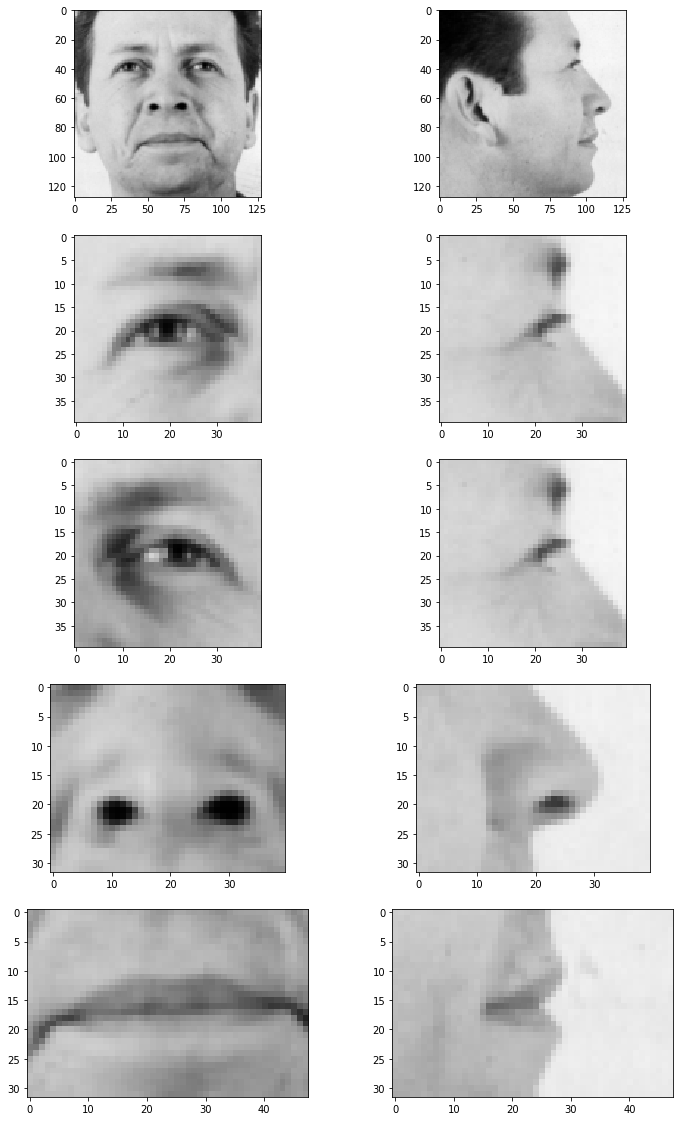

In [5]:
front, side, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s = load(PATH+'train/00001_1.png')
print(front.shape)
fig=plt.figure(figsize=(12, 20))
fig.add_subplot(5, 2, 1)
plt.imshow(front/255)
fig.add_subplot(5, 2, 2)
plt.imshow(side/255)
fig.add_subplot(5, 2, 3)
plt.imshow(eye1_f/255)
fig.add_subplot(5, 2, 4)
plt.imshow(eye1_s/255)
fig.add_subplot(5, 2, 5)
plt.imshow(eye2_f/255)
fig.add_subplot(5, 2, 6)
plt.imshow(eye2_s/255)
fig.add_subplot(5, 2, 7)
plt.imshow(nose_f/255)
fig.add_subplot(5, 2, 8)
plt.imshow(nose_s/255)
fig.add_subplot(5, 2, 9)
plt.imshow(mouth_f/255)
fig.add_subplot(5, 2, 10)
plt.imshow(mouth_s/255)
plt.show()

In [6]:
# normalizing the images to [-1, 1]
def normalize_single(im):
    return (im / 127.5) - 1

def normalize(front, side, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s):
    front = normalize_single(front)
    side = normalize_single(side)
    eye1_f = normalize_single(eye1_f)
    eye1_s = normalize_single(eye1_s)
    eye2_f = normalize_single(eye2_f)
    eye2_s = normalize_single(eye2_s)
    nose_f = normalize_single(nose_f)
    nose_s = normalize_single(nose_s)
    mouth_f = normalize_single(mouth_f)
    mouth_s = normalize_single(mouth_s)

    return front, side, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s

In [7]:
def load_image(image_file):
    front, side, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s = load(image_file)
    front, side, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s = normalize(front, side, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s)

    return front, side, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s, NOISE

## Input Pipeline

In [8]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.png')
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [9]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Definitions

In [10]:
lrelu=LeakyReLU()

### Light-CNN
Code taken directly from [LightCNN](https://github.com/AlfredXiangWu/LightCNN).

In [11]:
class LightCNN():

    def __init__(self, classes=None, extractor_type='29v2', extractor_weights=None, classifier_weights=None, in_size_hw=(128, 128)):
        """
        initialize light cnn network with given weights file. if weights file is None, the weights are initialized by default initializer.
        
        Args:
            classes (int): number of output classes. required when training or using classifier. not required when using only exractor.
            extractor_type (str): string of network type. must be one of the following strings "29v2", "29", "9".
            extractor_weights (str): trained extractor weights file path. it is used to resume training. not required when train from scratch.
            classifier_weights (str): trained classifier weights file path. it is used to resume training. not required when training from scratch or only using extractor.
            in_size_hw (tuple): height and width of input image. 
        """

        self.in_size_hw = in_size_hw
        self.num_classes = classes
        self.extractor_weights = extractor_weights
        self.classifier_weights = classifier_weights
        self._extractor = None
        self._classifier = None
        
        # if extractor_weights is not None, attempt to resume current epoch number from file name.
        if self.extractor_weights is not None:
            try:
                self.current_epochs = int(re.match(r'.+[_h]([0-9]+)\.hdf5', self.extractor_weights).groups()[0])
            except:
                print('trained epochs was not found in extractor_weights_file name. use 0 as current_epochs.')
                self.current_epochs = 0
        else:
            self.current_epochs = 0
            
        self.extractor_type = extractor_type
            
        
    def extractor(self):
        """
        getter for singleton extractor.
        """
        
        if self._extractor is None:
            if self.extractor_type == '29v2':
                self._extractor = self.build_extractor_29layers_v2(name='extract29v2', block=self._res_block, layers=[1, 2, 3, 4])
            elif self.extractor_type == '29':
                self._extractor = self.build_extractor_29layers(name='extract29', block=self._res_block, layers=[1, 2, 3, 4])
            elif self.extractor_type == '9':
                self._extractor = self.build_extractor_9layers(name='extract9')
        
            if self.extractor_weights is not None:
                self._extractor.load_weights(self.extractor_weights)
                
        return self._extractor
    
    def classifier(self):
        """
        getter for singleton classifier.
        """
        
        if self._classifier is None:
            self._classifier = self.build_classifier(name='classify')
            
        if self.classifier_weights is not None:
            self._classifier.load_weights(self.classifier_weights)
        
        return self._classifier
    
    
    def _mfm(self, X, name, out_channels, kernel_size=3, strides=1, dense=False):
        """
        private func for creating mfm layer.
        
        Todo:
            * maybe more natural if implemented as custom layer like the comment out code at the bottom of this file.
        """
        
        if dense:
            X = Dense(out_channels*2, name = name + '_dense1', kernel_regularizer=regularizers.l2(0.0005))(X)
        else:
            X = Conv2D(out_channels*2, name = name + '_conv2d1', kernel_size=kernel_size, kernel_regularizer=regularizers.l2(0.0005), strides=strides, padding='same')(X)
            
        X = Maximum()([Lambda(lambda x, c: x[..., :c], arguments={'c':out_channels})(X), Lambda(lambda x, c: x[..., c:], arguments={'c':out_channels})(X)])
        
        return X
    
    def _group(self, X, name, in_channels, out_channels, kernel_size, strides):
        
        X = self._mfm(X, name = name + '_mfm1', out_channels=in_channels, kernel_size=1, strides=1, dense=False)
        X = self._mfm(X, name = name + '_mfm2', out_channels=out_channels, kernel_size=kernel_size, strides=strides)
        
        return X
    
    def _res_block(self, X, name, out_channels):
        """
        private func for creating residual block with mfm layers.
        """
        
        X_shortcut = X
        X = self._mfm(X, name = name + '_mfm1', out_channels=out_channels, kernel_size=3, strides=1)
        X = self._mfm(X, name = name + '_mfm2', out_channels=out_channels, kernel_size=3, strides=1)
        X = Add()([X, X_shortcut])
        return X
    
    def _make_layer(self, X, name, block, num_blocks, out_channels):
        """
        private func for creating multiple blocks. block is usualy res_block.
        """
        
        for i in range(0, num_blocks):
            X = block(X, name = name + '_block{}'.format(i), out_channels=out_channels)
        return X

    def build_extractor_9layers(self, name):
        
        in_img = Input(shape=(*self.in_size_hw, 1))
        
        X = self._mfm(in_img, name = name + '_mfm1', out_channels=48, kernel_size=5, strides=1)
        X = MaxPooling2D(pool_size=2, padding='same')(X)
        X = self._group(X, name = name + '_group1', in_channels=48, out_channels=96, kernel_size=3, strides=1)
        X = MaxPooling2D(pool_size=2, padding='same')(X)        
        X = self._group(X, name = name + '_group2', in_channels=96, out_channels=192, kernel_size=3, strides=1)
        X = MaxPooling2D(pool_size=2, padding='same')(X) 
        X = self._group(X, name = name + '_group3', in_channels=192, out_channels=128, kernel_size=3, strides=1)
        X = self._group(X, name = name + '_group4', in_channels=128, out_channels=128, kernel_size=3, strides=1)
        feat_map = MaxPooling2D(pool_size=2, padding='same')(X)       
        feat_vec = Dense(256, name = name + '_dense1', kernel_regularizer=regularizers.l2(0.0005))(Flatten()(X))

        ret_extractor = Model(inputs=in_img, outputs=[feat_vec, feat_map], name=name)
        ret_extractor.summary()
        
        return ret_extractor
    
    def build_extractor_29layers(self, name, block, layers):
        
        in_img = Input(shape=(*self.in_size_hw, 1))
        
        X = self._mfm(in_img, name = name + '_mfm1', out_channels=48, kernel_size=5, strides=1)
        X = MaxPooling2D(pool_size=2, padding='same')(X)
        X = self._make_layer(X, name = name + '_layers1', block=block, num_blocks=layers[0], out_channels=48)
        X = self._group(X, name = name + '_group1', in_channels=48, out_channels=96, kernel_size=3, strides=1)
        X = MaxPooling2D(pool_size=2, padding='same')(X)
        X = self._make_layer(X, name = name + '_layers2', block=block, num_blocks=layers[1], out_channels=96)
        X = self._group(X, name = name + '_group2', in_channels=96, out_channels=192, kernel_size=3, strides=1)
        X = MaxPooling2D(pool_size=2, padding='same')(X)
        X = self._make_layer(X, name = name + '_layers3', block=block, num_blocks=layers[2], out_channels=192)
        X = self._group(X, name = name + '_group3', in_channels=192, out_channels=128, kernel_size=3, strides=1)
        X = self._make_layer(X, name = name + '_layers4', block=block, num_blocks=layers[3], out_channels=128)
        X = self._group(X, name = name + '_group4', in_channels=128, out_channels=128, kernel_size=3, strides=1)
        feat_map = MaxPooling2D(pool_size=2, padding='same')(X)
        feat_vec = self._mfm(Flatten()(feat_map), name = name + '_mfm2', out_channels=256, dense=True)

        ret_extractor = Model(inputs=in_img, outputs=[feat_vec, feat_map], name=name)
        ret_extractor.summary()
        
        return ret_extractor
                    
    def build_extractor_29layers_v2(self, name, block, layers):
        
        in_img = Input(shape=(*self.in_size_hw, 1))
        
        X = self._mfm(in_img, name = name + '_mfm1', out_channels=48, kernel_size=5, strides=1)
        X = Average()([MaxPooling2D(pool_size=2, padding='same')(X), AveragePooling2D(pool_size=2, padding='same')(X)])
        X = self._make_layer(X, name = name + '_layers1', block=block, num_blocks=layers[0], out_channels=48)
        X = self._group(X, name = name + '_group1', in_channels=48, out_channels=96, kernel_size=3, strides=1)
        X = Average()([MaxPooling2D(pool_size=2, padding='same')(X), AveragePooling2D(pool_size=2, padding='same')(X)])
        X = self._make_layer(X, name = name + '_layers2', block=block, num_blocks=layers[1], out_channels=96)
        X = self._group(X, name = name + '_group2', in_channels=96, out_channels=192, kernel_size=3, strides=1)
        X = Average()([MaxPooling2D(pool_size=2, padding='same')(X), AveragePooling2D(pool_size=2, padding='same')(X)])
        X = self._make_layer(X, name = name + '_layers3', block=block, num_blocks=layers[2], out_channels=192)
        X = self._group(X, name = name + '_group3', in_channels=192, out_channels=128, kernel_size=3, strides=1)
        X = self._make_layer(X, name = name + '_layers4', block=block, num_blocks=layers[3], out_channels=128)
        X = self._group(X, name = name + '_group4', in_channels=128, out_channels=128, kernel_size=3, strides=1)
        feat_map = Average()([MaxPooling2D(pool_size=2, padding='same')(X), AveragePooling2D(pool_size=2, padding='same')(X)])
        feat_vec = Dense(256, name = name + '_dense1', kernel_regularizer=regularizers.l2(0.0005))(Flatten()(feat_map))
        
        ret_extractor = Model(inputs=in_img, outputs=[feat_vec, feat_map], name=name)        
        ret_extractor.summary()
        
        return ret_extractor
    
    def build_classifier(self, name):
        
        in_feat = Input(shape=(256,))
        X = Dropout(0.7)(in_feat)
               
        X = Dense(500, activation='relu', name = name + '_dense1', kernel_regularizer=regularizers.l2(0.005))(X)
        X = Dropout(0.7)(X)
    
        clas = Dense(self.num_classes, activation='softmax', name = name + '_dense2', use_bias=False , kernel_regularizer=regularizers.l2(0.005))(X)
        
        ret_classifier = Model(inputs=in_feat, outputs=clas, name=name)
        
        ret_classifier.summary()
        return ret_classifier
        

    def train(self, train_gen, valid_gen=None, optimizer=SGD(lr=0.001, momentum=0.9, decay=0.00004, nesterov=True),
              classifier_dropout=0.7, steps_per_epoch=100, validation_steps=100,
              epochs=1, out_dir='../out/', out_period=1, fix_extractor=False):
        """
        train extractor and classifier.
        
        Args:
            train_gen (generator): train data generator provided by celeb_gen.
            valid_gen (generator): valid data generator provided by celeb_gen.
            optimizer (Optimizer): keras optimizer used to train.
            classifier_dropout (float): dropout ratio for training classifier.
            steps_per_epoch (int): steps for each epoch. 
            validation_steps (int): steps for validation on the end of each epoch.
            epochs (int): epochs to train.
            out_prefix (str): prefix str for output weights file.
            out_period (int): interval epochs for output weights file.
            fix_extractor (bool): if true, train only classifier. if false, train both extractor and classifier.
        """        
        
        self.classifier().trainable = True
        self.extractor().trainable = not fix_extractor           
        
        for layer in self.classifier().layers:
            if type(layer) == Dropout:
                layer.rate = classifier_dropout
        
        train_model = Sequential([Model(inputs=self.extractor().inputs, outputs=self.extractor().outputs[0]), self.classifier()])
        train_model.summary()
        
        train_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
        
        if out_dir != '':
            tf.gfile.MakeDirs(out_dir)
        
        history = train_model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs+self.current_epochs, workers=0, validation_data=valid_gen, validation_steps=validation_steps, initial_epoch=self.current_epochs)
        self.current_epochs += epochs
                    
        return history
    
    def evaluate(self, generator, steps=100):
        
        train_model = Sequential([Model(inputs=self.extractor().inputs, outputs=self.extractor().outputs[0]), self.classifier()])
        train_model.summary()
        
        train_model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['acc'])

        score = train_model.evaluate_generator(generator, steps=steps)
                    
        return {'loss':score[0], 'acc':score[1]}
    
    def predict_class(self, gray_img_batch):
        feat = self.extractor().predict(gray_img_batch)
        clas = self.classifier().predict(feat)
        return np.argmax(clas, axis=-1)
    
    def exract_features(self, gray_img_batch):
        feat = self.extractor().predict(gray_img_batch)
        return feat

In [12]:
# Load light-cnn pre-trained weights
lcnn = LightCNN(extractor_type='29v2', extractor_weights='light-cnn/extract29v2_lr0.00010_loss0.997_valacc1.000_epoch1110.hdf5')
lcnn.extractor().trainable = False

trained epochs was not found in extractor_weights_file name. use 0 as current_epochs.
Model: "extract29v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
extract29v2_mfm1_conv2d1 (Conv2 (None, 128, 128, 96) 2496        input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 48) 0           extract29v2_mfm1_conv2d1[0][0]   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 48) 0           extract29v2_mfm1_conv2d1[0][0]   
__

OSError: Unable to open file (unable to open file: name = 'light-cnn/extract29v2_lr0.00010_loss0.997_valacc1.000_epoch1110.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Residual Block an Landmark Part Rotator
Code adapted from:
  - [TP-GAN official implementation](https://github.com/HRLTY/TP-GAN)
  - [TP-GAN Keras implementation](https://github.com/yh-iro/Keras_TP-GAN)

In [13]:

def res_block(model, kernel_size, name, batch_norm=True):
    model_shortcut = model
    
    for i in range(2):
        if (batch_norm == True):
            model = Conv2D(model.shape[-1], kernel_size, strides=(1, 1), padding='same', use_bias=False,
                       kernel_initializer=TruncatedNormal(stddev=0.02), name=name+'_res'+str(i))(model)
            model = BatchNormalization(epsilon=1e-5, name=name+'_res'+str(i)+'_bn')(model)
        else:
            model = Conv2D(model.shape[-1], kernel_size, strides=(1, 1), padding='same', use_bias=True,
                       kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=Zeros(), name=name+'_res'+str(i))(model)
        model = Activation(lrelu, name=name+'_res'+str(i)+'_lrelu')(model)
    
    model = Add()([model_shortcut, model])
    return model

In [14]:
def build_part_rotator(name, in_h, in_w):
        
        in_img = Input(shape=(in_h, in_w, 3))
        
        c0 = Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='c0', kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=Zeros())(in_img)
        c0r = res_block(c0, (3, 3), batch_norm=True, name='c0_r')
        c1 = Conv2D(64*2, (3, 3), padding='same', strides=(2, 2), name='c1', use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02))(c0r)
        c1 = BatchNormalization(name='c1_bn')(c1)
        c1 = Activation(lrelu, name='c1_lrelu')(c1)
        
        c1r = res_block(c1, (3, 3), batch_norm=True, name='c1_r')
        c2 = Conv2D(64*4, (3, 3), padding='same', strides=(2, 2), name='c2', use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02))(c1r)
        c2 = BatchNormalization(name='c2_bn')(c2)
        c2 = Activation(lrelu, name='c2_lrelu')(c2)
        
        c2r = res_block(c2, (3, 3), batch_norm=True, name='c2_r')
        c3 = Conv2D(64*8, (3, 3), padding='same', strides=(2, 2), name='c3', use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02))(c2r)
        c3 = BatchNormalization(name='c3_bn')(c3)
        c3 = Activation(lrelu, name='c3_lrelu')(c3)
        
        c3r = res_block(c3, (3, 3), batch_norm=True, name='c3_r')
        c3r2 = res_block(c3r, (3, 3), batch_norm=True, name='c3_r2')
        
        d1 = Conv2DTranspose(64*4, (3, 3), padding='same', strides=(2, 2), name='d1', use_bias=True, kernel_initializer=RandomNormal(stddev=0.02))(c3r2)
        d1 = BatchNormalization(name='d1_bn')(d1)
        d1 = Activation(lrelu, name='d1_lrelu')(d1)
        
        after_select_d1 = Conv2D(64*4, (3, 3), padding='same', strides=(1, 1), name='asd1', use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02))(Concatenate()([d1, c2r]))
        after_select_d1 = BatchNormalization(name='asd1_bn')(after_select_d1)
        after_select_d1 = Activation(lrelu, name='after_select_d1_lrelu')(after_select_d1)
        d1r = res_block(after_select_d1, (3, 3), batch_norm=True, name='d1_r')
        d2 = Conv2DTranspose(64*2, (3, 3), padding='same', strides=(2, 2), name='d2', use_bias=False, kernel_initializer=RandomNormal(stddev=0.02))(d1r)
        d2 = BatchNormalization(name='d2_bn')(d2)
        d2 = Activation(lrelu, name='d2_lrelu')(d2)
        
        after_select_d2 = Conv2D(64*2, (3, 3), padding='same', strides=(1, 1), name='asd2', use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02))(Concatenate()([d2, c1r]))
        after_select_d2 = BatchNormalization(name='asd2_bn')(after_select_d2)
        after_select_d2 = Activation(lrelu, name='after_select_d2_lrelu')(after_select_d2)
        d2r = res_block(after_select_d2, (3, 3), batch_norm=True, name='d2_r')
        d3 = Conv2DTranspose(64, (3, 3), padding='same', strides=(2, 2), name='d3', use_bias=False, kernel_initializer=RandomNormal(stddev=0.02))(d2r)
        d3 = BatchNormalization(name='d3_bn')(d3)
        d3 = Activation(lrelu, name='d3_lrelu')(d3)
        
        after_select_d3 = Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='asd3', use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02))(Concatenate()([d3, c0r]))
        after_select_d3 = BatchNormalization(name='asd3_bn')(after_select_d3)
        after_select_d3 = Activation(lrelu, name='after_select_d3_lrelu')(after_select_d3)
        part_feat = res_block(after_select_d3, (3, 3), batch_norm=True, name='d3_r')
        
        part_img = Conv2D(3, (3, 3), padding='same', strides=(1, 1), activation='tanh', name='c4', kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=Zeros())(part_feat)

        ret_model = Model(inputs=[in_img], outputs=[part_img, part_feat], name=name + '_rotator')
        ret_model.summary()
        
        return ret_model

In [15]:
leye_rotator = build_part_rotator('leye', in_h=40 , in_w=40)
reye_rotator = build_part_rotator('reye', in_h=40 , in_w=40)
nose_rotator = build_part_rotator('nose', in_h=32 , in_w=40)
mouth_rotator = build_part_rotator('mouth', in_h=32 , in_w=48)

in_leye = Input(shape=(40, 40, 3))
in_reye = Input(shape=(40, 40, 3))
in_nose = Input(shape=(32, 40, 3))
in_mouth = Input(shape=(32, 48, 3))

out_leye_img, out_leye_feat = leye_rotator(in_leye)
out_reye_img, out_reye_feat = reye_rotator(in_reye)
out_nose_img, out_nose_feat = nose_rotator(in_nose)
out_mouth_img, out_mouth_feat = mouth_rotator(in_mouth)

parts_rotator = Model(inputs=[in_leye, in_reye, in_nose, in_mouth],
                    outputs=[out_leye_img, out_leye_feat, out_reye_img, out_reye_feat, out_nose_img, out_nose_feat, out_mouth_img, out_mouth_feat], name='parts_rotator')
parts_rotator.summary()

Model: "leye_rotator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40, 40, 3)]  0                                            
__________________________________________________________________________________________________
c0 (Conv2D)                     (None, 40, 40, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
c0_r_res0 (Conv2D)              (None, 40, 40, 64)   36864       c0[0][0]                         
__________________________________________________________________________________________________
c0_r_res0_bn (BatchNormalizatio (None, 40, 40, 64)   256         c0_r_res0[0][0]                  
_______________________________________________________________________________________

Model: "reye_rotator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40, 40, 3)]  0                                            
__________________________________________________________________________________________________
c0 (Conv2D)                     (None, 40, 40, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
c0_r_res0 (Conv2D)              (None, 40, 40, 64)   36864       c0[0][0]                         
__________________________________________________________________________________________________
c0_r_res0_bn (BatchNormalizatio (None, 40, 40, 64)   256         c0_r_res0[0][0]                  
_______________________________________________________________________________________

Model: "nose_rotator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 40, 3)]  0                                            
__________________________________________________________________________________________________
c0 (Conv2D)                     (None, 32, 40, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
c0_r_res0 (Conv2D)              (None, 32, 40, 64)   36864       c0[0][0]                         
__________________________________________________________________________________________________
c0_r_res0_bn (BatchNormalizatio (None, 32, 40, 64)   256         c0_r_res0[0][0]                  
_______________________________________________________________________________________

Model: "mouth_rotator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 48, 3)]  0                                            
__________________________________________________________________________________________________
c0 (Conv2D)                     (None, 32, 48, 64)   1792        input_5[0][0]                    
__________________________________________________________________________________________________
c0_r_res0 (Conv2D)              (None, 32, 48, 64)   36864       c0[0][0]                         
__________________________________________________________________________________________________
c0_r_res0_bn (BatchNormalizatio (None, 32, 48, 64)   256         c0_r_res0[0][0]                  
______________________________________________________________________________________

Model: "parts_rotator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 40, 40, 3)]  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 40, 40, 3)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 32, 40, 3)]  0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 32, 48, 3)]  0                                            
______________________________________________________________________________________

In [16]:
def combine_parts(size_hw, leye, reye, nose, mouth):
    EYE_H, EYE_W = 40, 40
    NOSE_H, NOSE_W = 32, 40
    MOUTH_H, MOUTH_W = 32, 48
    IMAGE_SIZE = 128
    eyel_p = tf.pad(leye, [[0,0], [int(41 - EYE_H / 2 - 1), int(IMAGE_SIZE - (41+EYE_H/2 - 1))], [int(44 - EYE_W / 2 - 1), int(IMAGE_SIZE - (44+EYE_W/2-1))], [0,0]], constant_values=1.0)
    eyer_p = tf.pad(reye, [[0,0], [int(41 - EYE_H / 2 - 1), int(IMAGE_SIZE - (41+EYE_H/2 - 1))], [int(86 - EYE_W / 2 - 1), int(IMAGE_SIZE - (86+EYE_W/2-1))], [0,0]], constant_values=1.0)
    nose_p = tf.pad(nose, [[0,0], [int(65 - NOSE_H / 2 - 1), int(IMAGE_SIZE - (65+NOSE_H/2 - 1))], [int(64 - NOSE_W / 2 - 1), int(IMAGE_SIZE - (64+NOSE_W/2-1))], [0,0]], constant_values=1.0)
    month_p = tf.pad(mouth, [[0,0], [int(89 - MOUTH_H / 2 - 1), int(IMAGE_SIZE - (89+MOUTH_H/2 - 1))], [int(65 - MOUTH_W / 2 - 1), int(IMAGE_SIZE - (65+MOUTH_W/2-1))], [0,0]], constant_values=1.0)
    eyes = tf.minimum(eyel_p, eyer_p)
    eye_nose = tf.minimum(eyes, nose_p)
    return tf.minimum(eye_nose, month_p)

### Generator
Code adapted from:
  - [TP-GAN official implementation](https://github.com/HRLTY/TP-GAN)
  - [TP-GAN Keras implementation](https://github.com/yh-iro/Keras_TP-GAN)

In [17]:
encoder_in = Input(shape=(128,128,3))
mc_in_img128 = Concatenate()([encoder_in, Lambda(lambda x: x[:,:,::-1,:])(encoder_in)])
mc_in_img64 = tf.image.resize(mc_in_img128, [64, 64], method=tf.image.ResizeMethod.BILINEAR)
mc_in_img32 = tf.image.resize(mc_in_img64, [32, 32], method=tf.image.ResizeMethod.BILINEAR)

#conv0
conv0 = Conv2D(64, (7, 7), strides=(1, 1), padding='same', name='global_enc_conv0',
               use_bias=True, kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=Zeros())(encoder_in)
conv0 = Activation(lrelu, name='global_enc_conv0_lrelu')(conv0)
conv0 = res_block(conv0, (7, 7), 'global_enc_conv0_r1')

#conv1
conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,
               kernel_initializer=TruncatedNormal(stddev=0.02), name='global_enc_conv1')(conv0)
conv1 = BatchNormalization(epsilon=1e-5, name='global_enc_conv1_bn1')(conv1)
conv1 = Activation(lrelu, name='global_enc_conv1_lrelu')(conv1)
conv1 = res_block(conv1, (5, 5), 'global_enc_conv1_r1')

#conv2
conv2 = Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False,
               kernel_initializer=TruncatedNormal(stddev=0.02), name='global_enc_conv2')(conv1)
conv2 = BatchNormalization(epsilon=1e-5, name='global_enc_conv2_bn1')(conv2)
conv2 = Activation(lrelu, name='global_enc_conv2_lrelu')(conv2)
conv2 = res_block(conv2, (3, 3), 'global_enc_conv2_r1')

#conv3
conv3 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', use_bias=False,
               kernel_initializer=TruncatedNormal(stddev=0.02), name='global_enc_conv3')(conv2)
conv3 = BatchNormalization(epsilon=1e-5, name='global_enc_conv3_bn1')(conv3)
conv3 = Activation(lrelu, name='global_enc_conv3_lrelu')(conv3)
conv3 = res_block(conv3, (3, 3), 'global_enc_conv3_r1')

#conv4
conv4 = Conv2D(512, (3, 3), strides=(2, 2), padding='same', use_bias=False,
               kernel_initializer=TruncatedNormal(stddev=0.02), name='global_enc_conv4')(conv3)
conv4 = BatchNormalization(epsilon=1e-5, name='global_enc_conv4_bn1')(conv4)
conv4 = Activation(lrelu, name='global_enc_conv4_lrelu')(conv4)
conv4 = res_block(conv4, (3, 3), 'global_enc_conv4_r1')
conv4 = res_block(conv4, (3, 3), 'global_enc_conv4_r2')
conv4 = res_block(conv4, (3, 3), 'global_enc_conv4_r3')
conv4 = res_block(conv4, (3, 3), 'global_enc_conv4_r4')

###
encoder_out = Flatten(name='global_enc_flatten')(conv4)
encoder_out = Dense(512, name='global_enc_dense')(encoder_out)

encoder_out = Maximum()([Lambda(lambda x: x[:, :256])(encoder_out), Lambda(lambda x: x[:, 256:])(encoder_out)])

z = Input(shape=(100,))


fc2_with_noise = Concatenate()([encoder_out, z])
fc3 = Dense(4096, name='dense123', kernel_initializer=RandomNormal(stddev=0.02), bias_initializer=Constant(0.1))(fc2_with_noise)
f8 = Conv2DTranspose(64, (8, 8), padding='valid', strides=(1, 1), name='f8', activation='relu',
                     kernel_initializer=RandomNormal(stddev=0.02), bias_initializer=Zeros())(Reshape((1, 1, 4096))(fc3))

f32 = Conv2DTranspose(32, (3, 3), padding='same', strides=(4, 4), name='f16',
                      kernel_initializer=RandomNormal(stddev=0.02), bias_initializer=Zeros(), activation='relu')(f8)

f64 = Conv2DTranspose(16, (3, 3), padding='same', strides=(2, 2), name='f64',
                      kernel_initializer=RandomNormal(stddev=0.02), bias_initializer=Zeros(), activation='relu')(f32)
    
f128 = Conv2DTranspose(8, (3, 3), padding='same', strides=(2, 2), name='f128',
                       kernel_initializer=RandomNormal(stddev=0.02), bias_initializer=Zeros(), activation='relu')(f64)

#----

d8 = Concatenate(name='d8')([conv4, f8])
d8r = res_block(d8, (3, 3), name='d8_r')
d8r2 = res_block(d8r, (3, 3), name='d8_r2')
d8r3 = res_block(d8r2, (3, 3), name='d8_r3')

d16 = Conv2DTranspose(512, (3, 3), padding='same', strides=(2, 2), name='d16', use_bias=False,
                      kernel_initializer=RandomNormal(stddev=0.02))(d8r3)
d16 = BatchNormalization(epsilon=1e-5, name='d16_bn')(d16)
d16 = Activation('relu', name='d16_relu')(d16)
d16r = res_block(conv3, (3, 3), name='d16_r')
d16r2 = res_block(Concatenate()([d16, d16r]), (3, 3), name='d16_r2')
d16r3 = res_block(d16r2, (3, 3), name='d16_r3')

d32 = Conv2DTranspose(256, (3, 3), padding='same', strides=(2, 2), name='d32', use_bias=False,
                      kernel_initializer=RandomNormal(stddev=0.02))(d16r3)
d32 = BatchNormalization(epsilon=1e-5, name='d32_bn')(d32)
d32 = Activation('relu', name='d32_relu')(d32)
d32r = res_block(Concatenate()([conv2, mc_in_img32, f32]), (3, 3), name='d32_r')
d32r2 = res_block(Concatenate()([d32, d32r]), (3, 3), name='d32_r2')
d32r3 = res_block(d32r2, (3, 3), name='d32_r3')
img32 = Conv2D(3, (3, 3), padding='same', strides=(1, 1), activation='tanh', name='img32',
               kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=Zeros())(d32r3)

d64 = Conv2DTranspose(128, (3, 3), padding='same', strides=(2, 2), name='d64', use_bias=False,
                      kernel_initializer=RandomNormal(stddev=0.02))(d32r3)
d64 = BatchNormalization(epsilon=1e-5, name='d64_bn')(d64)
d64 = Activation('relu', name='d64_relu')(d64)
d64r = res_block(Concatenate()([conv1, mc_in_img64, f64]), (5, 5), name='d64_r')

interpolated64 = tf.image.resize(img32, [64, 64], method=tf.image.ResizeMethod.BILINEAR)

d64r2 = res_block(Concatenate()([d64, d64r, interpolated64]), (3, 3), name='d64_r2')
d64r3 = res_block(d64r2, (3, 3), name='d64_r3')
img64 = Conv2D(3, (3, 3), padding='same', strides=(1, 1), activation='tanh', name='img64',
               kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=Zeros())(d64r3)

d128 = Conv2DTranspose(64, (3, 3), padding='same', strides=(2, 2), name='d128', use_bias=False,
                       kernel_initializer=RandomNormal(stddev=0.02))(d64r3)
d128 = BatchNormalization(epsilon=1e-5, name='d128_bn')(d128)
d128 = Activation('relu', name='d128_relu')(d128)
d128r = res_block(Concatenate()([conv0, mc_in_img128, f128]), (5, 5), name='d128_r')

interpolated128 = tf.image.resize(img64, [128, 128], method=tf.image.ResizeMethod.BILINEAR)

in_leye = Input(shape=(40, 40, 3))
in_reye = Input(shape=(40, 40, 3))
in_nose = Input(shape=(32, 40, 3))
in_mouth = Input(shape=(32, 48, 3))

front_leye_img, front_leye_feat, front_reye_img, front_reye_feat, front_nose_img, front_nose_feat, front_mouth_img, front_mouth_feat\
        = parts_rotator([in_leye, in_reye, in_nose, in_mouth])

combined_parts_img = combine_parts([128, 128], front_leye_img, front_reye_img, front_nose_img, front_mouth_img)
combined_parts_feat = combine_parts([128, 128], front_leye_feat, front_reye_feat, front_nose_feat, front_mouth_feat)

##
d128r2 = res_block(Concatenate()([d128, d128r, interpolated128, combined_parts_feat, combined_parts_img]), (3, 3), batch_norm=True, name='d128_r2')
d128r2c = Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='d128_r2c', use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02))(d128r2)
d128r2c = BatchNormalization(epsilon=1e-5, name='d128_r2c_bn')(d128r2c)
d128r2c = Activation(lrelu, name='d128r2c_lrelu')(d128r2c)
d128r3c = res_block(d128r2c, (3, 3), batch_norm=True, name='d128_r3c')
d128r3c2 = Conv2D(64//2, (3, 3), padding='same', strides=(1, 1), name='d128_r3c2', use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02))(d128r3c)
d128r3c2 = BatchNormalization(epsilon=1e-5, name='d128_r3c2_bn')(d128r3c2)
d128r3c2 = Activation(lrelu, name='d128r3c2_lrelu')(d128r3c2)
img128 = Conv2D(3, (3, 3), padding='same', strides=(1, 1), activation='tanh', name='img128', kernel_initializer=TruncatedNormal(stddev=0.02), bias_initializer=Zeros())(d128r3c2)

generator = Model(inputs=[encoder_in, in_leye, in_reye, in_nose, in_mouth, z], outputs=[img128, img64, img32, front_leye_img, front_reye_img, front_nose_img, front_mouth_img, combined_parts_img], name='generator')        
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
global_enc_conv0 (Conv2D)       (None, 128, 128, 64) 9472        input_10[0][0]                   
__________________________________________________________________________________________________
global_enc_conv0_lrelu (Activat (None, 128, 128, 64) 0           global_enc_conv0[0][0]           
__________________________________________________________________________________________________
global_enc_conv0_r1_res0 (Conv2 (None, 128, 128, 64) 200704      global_enc_conv0_lrelu[0][0]     
__________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


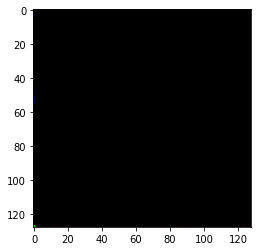

In [18]:
gen_output = generator([side[tf.newaxis,...], eye1_s[tf.newaxis,...], eye2_s[tf.newaxis,...], nose_s[tf.newaxis,...], mouth_s[tf.newaxis,...], NOISE[tf.newaxis,...]], training=False)
plt.imshow(gen_output[0][0])

In [19]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
lambda_128=1
lambda_64=1
lambda_32=1.5
lambda_sym=3e-1
lambda_ip=1
lambda_adv=2
lambda_tv=1e-3
lambda_parts=3

# Generator Loss
def generator_loss(disc_generated_output, gen128, tar128, gen64, gen32,
                   geneye1, tareye1, geneye2, tareye2, gennose, tarnose, genmouth, tarmouth):
    # pixel loss
    pix_loss = lambda_128 * tf.reduce_mean(tf.abs(tar128 - gen128))
    pix_loss += lambda_64 * tf.reduce_mean(tf.abs(tf.image.resize(tar128, [64, 64], method=tf.image.ResizeMethod.BILINEAR) - gen64))
    pix_loss += lambda_32 * tf.reduce_mean(tf.abs(tf.image.resize(tar128, [32, 32], method=tf.image.ResizeMethod.BILINEAR) - gen32))
    
    # symmetry loss
    sym_loss = lambda_128 * lambda_sym * tf.reduce_mean(tf.abs(gen128[:,:,::-1,:] - gen128))
    sym_loss += lambda_64 * lambda_sym * tf.reduce_mean(tf.abs(gen64[:,:,::-1,:] - gen64))
    sym_loss += lambda_32 * lambda_sym * tf.reduce_mean(tf.abs(gen32[:,:,::-1,:] - gen32))
    
    # adversarial loss
    adv_loss = lambda_adv * loss_object(tf.ones_like(disc_generated_output) * 0.9, disc_generated_output)
    
    # identity-preserving loss
    vec_true, map_true = lcnn.extractor()(tf.image.rgb_to_grayscale(tar128 * 0.5 + 0.5))
    vec_pred, map_pred = lcnn.extractor()(tf.image.rgb_to_grayscale(gen128 * 0.5 + 0.5))
    ip_loss = lambda_ip * (tf.reduce_mean(tf.abs(vec_pred - vec_true)) + tf.reduce_mean(tf.abs(map_pred - map_true)))
    
    # total variation loss
    tv_loss = lambda_tv * tf.reduce_mean(tf.image.total_variation(gen128))
    
    # face part loss
    part_loss = lambda_parts * tf.reduce_mean(tf.abs(tareye1 - geneye1))
    part_loss += lambda_parts * tf.reduce_mean(tf.abs(tareye2 - geneye2))
    part_loss += lambda_parts * tf.reduce_mean(tf.abs(tarnose - gennose))
    part_loss += lambda_parts * tf.reduce_mean(tf.abs(tarmouth - genmouth))

    total_gen_loss = pix_loss + sym_loss+ adv_loss + ip_loss + tv_loss + part_loss

    return total_gen_loss, adv_loss, pix_loss, sym_loss, ip_loss, tv_loss, part_loss

### Discriminator
Code adapted from [Pix2Pix Tensor flow docs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb).

In [21]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(x) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate_21 (Concatenate)    (None, 128, 128, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  12800       concatenate_21[0][0]         

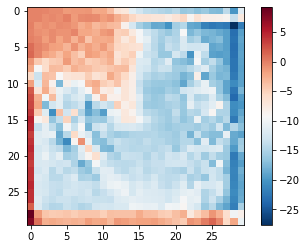

In [22]:
disc_out = discriminator([side[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], cmap='RdBu_r')
plt.colorbar()

In [23]:
# Discriminator Loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output) * 0.9, disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    #total_disc_loss = loss_object(disc_real_output * 0.9, disc_generated_output)

    return total_disc_loss

In [24]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
checkpoint_dir = 'checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

In [26]:
def generate_images(model, test_input, tar, eye1_s, eye2_s, nose_s, mouth_s, noise):
    prediction = model([test_input, eye1_s, eye2_s, nose_s, mouth_s, noise], training=True)[0]
    plt.figure(figsize=(8,8))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

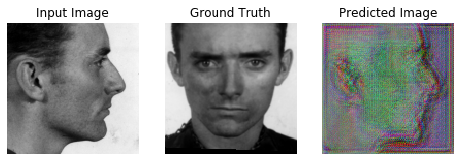

In [27]:
for front, side, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s, noise in test_dataset.take(1):
    generate_images(generator, side, front, eye1_s, eye2_s, nose_s, mouth_s, noise)

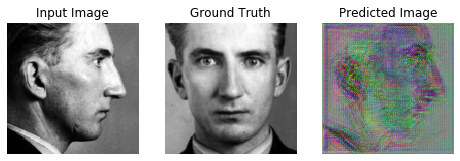

In [28]:
BASELINE_IMG = PATH+'test/00596_1.png'
baseline_dataset = tf.data.Dataset.list_files(BASELINE_IMG)
baseline_dataset = baseline_dataset.map(load_image)
baseline_dataset = baseline_dataset.batch(BATCH_SIZE)
for baseline_tar, baseline_in, eye1_f, baseline_eye1, eye2_f, baseline_eye2, nose_f, baseline_nose, mouth_f, baseline_mouth, noise in baseline_dataset.take(1):
    generate_images(generator, baseline_in, baseline_tar, baseline_eye1, baseline_eye2, baseline_nose, baseline_mouth, noise)

In [29]:
def baseline_image(model, test_input, tar, eye1_s, eye2_s, nose_s, mouth_s, epoch):
    baseline_dir = 'baselines'
    if not os.path.isdir(baseline_dir):
        os.makedirs(baseline_dir)

    img_name = baseline_dir + '/epoch_%d.png' % epoch
    prediction = model([test_input, eye1_s, eye2_s, nose_s, mouth_s, NOISE[tf.newaxis,...]], training=True)[0]
    fig = plt.figure(figsize=(8,4))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig(img_name, bbox_inches='tight')
    plt.close()
    fig.clf()
    return img_name

## Training

In [30]:
EPOCHS = 1000

In [31]:
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [32]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(None, 40, 40, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(None, 40, 40, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(None, 40, 40, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(None, 40, 40, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(None, 32, 40, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(None, 32, 40, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(None, 32, 48, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(None, 32, 48, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(None, 100), dtype=tf.float32),
                             tf.TensorSpec(shape=(), dtype=tf.int64)])
def train_step(target, input_image, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s, noise, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen128, gen64, gen32, geneye1, geneye2, gennose, genmouth, combined_parts_img =\
            generator([input_image, eye1_s, eye2_s, nose_s, mouth_s, noise], training=True)

        #disc_real_output = discriminator(target, training=True)
        #disc_generated_output = discriminator(gen128, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen128], training=True)

        total_gen_loss, adv_loss, pix_loss, sym_loss, ip_loss, tv_loss, part_loss =\
            generator_loss(disc_generated_output, gen128, target, gen64, gen32,
                   geneye1, eye1_f, geneye2, eye2_f, gennose, nose_f, genmouth, mouth_f)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(total_gen_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('total_gen_loss', total_gen_loss, step=epoch)
        tf.summary.scalar('adv_loss', pix_loss, step=epoch)
        tf.summary.scalar('pix_loss', pix_loss, step=epoch)
        tf.summary.scalar('sym_loss', sym_loss, step=epoch)
        tf.summary.scalar('ip_loss', ip_loss, step=epoch)
        tf.summary.scalar('tv_loss', tv_loss, step=epoch)
        tf.summary.scalar('part_loss', part_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [33]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    epoch = epoch + 1000
    start = time.time()

    baseline_image(generator, baseline_in, baseline_tar, baseline_eye1, baseline_eye2, baseline_nose, baseline_mouth, epoch)
    baseline_file = baseline_image(generator, baseline_in, baseline_tar, baseline_eye1, baseline_eye2, baseline_nose, baseline_mouth, epoch)
    raw_img = tf.io.read_file(baseline_file)
    baseline_img = tf.image.decode_png(raw_img, channels=1)
    with summary_writer.as_default():
      tf.summary.image("Test Baseline", np.reshape(baseline_img,(-1, baseline_img.shape[0],
                                                                 baseline_img.shape[1], baseline_img.shape[2])), step=epoch)

    print("Epoch: ", epoch)

    # Train
    for n, (target, input_image, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s, noise) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(target, input_image, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s, noise, epoch)
    print()

    # saving (checkpoint) the model every 40 epochs
    if (epoch + 1) % 40 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    display.clear_output(wait=True)
    print ('Time taken for epoch {} is {} sec\n'.format(epoch, time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
start = time.time()
fit(train_dataset, EPOCHS, test_dataset)
end = time.time()
print("Training time: %f hours" % ((end - start) / 60 / 60))

In [34]:
# Restore checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

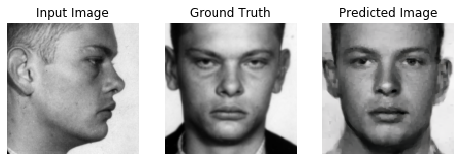

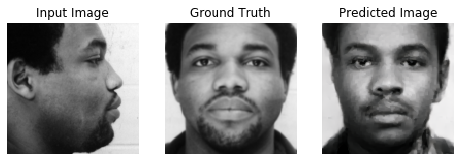

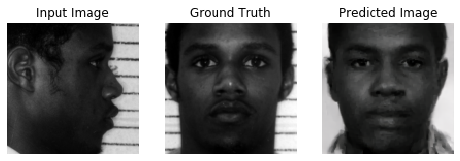

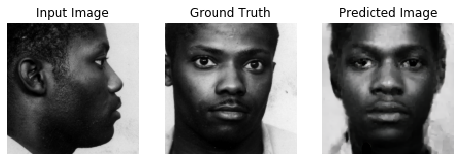

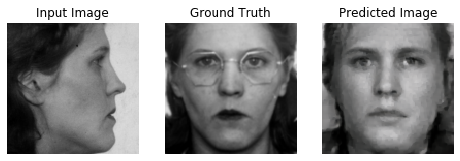

In [35]:
# Run the trained model test set
for target, input_image, eye1_f, eye1_s, eye2_f, eye2_s, nose_f, nose_s, mouth_f, mouth_s, noise in test_dataset.take(5):
  generate_images(generator, input_image, target, eye1_s, eye2_s, nose_s, mouth_s, noise)